In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package
sys.path.append("../..")

# Third party imports
import pandas as pd
import numpy as np

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-10-17 23:47:33.679706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-17 23:47:33.679728: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from librep.metrics.report import ClassificationReport
import yaml

In [4]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../../data/old-views/KuHar/resampled_view_20Hz")

In [5]:
# Kuhar dataframes
train, validation, test = PandasDatasetsIO(dataset_path).load()

In [6]:
train.head()

,Unnamed: 0,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,normalized activity code
0,0,0.001911,-0.014536,0.005845,0.003675,-0.014972,0.025607,0.000478,-0.031141,-0.014827,...,23.235,23.223,26.260,26.249,0,300,1,2100,1051,1
1,1,0.004114,-0.003186,0.000759,0.012450,-0.032074,0.007270,-0.000470,0.006980,0.021400,...,56.292,56.292,59.245,59.245,0,300,1,5700,1037,1
2,2,-0.011282,-0.002432,-0.003199,0.008152,-0.021763,0.000309,-0.004968,-0.009551,0.001497,...,27.268,27.267,30.290,30.291,0,300,1,2700,1075,1
3,3,-0.009241,-0.004666,0.021606,-0.007200,0.003091,0.001630,0.005057,-0.008149,0.013167,...,39.421,39.420,42.441,42.440,0,300,6,3900,1008,1
4,4,-0.013083,-0.005612,0.001645,0.006823,-0.004159,0.000415,0.008178,0.002637,-0.000827,...,23.703,23.703,26.656,26.656,0,300,1,2400,1038,1


In [7]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Validation
validation_dataset = PandasMultiModalDataset(
    validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Test
test_dataset = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

In [8]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [9]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

In [10]:
train_dataset_fft = transformer(train_dataset)
validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test_dataset)

In [11]:
print(train_dataset_fft.X.shape)
print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3330, 180)
(108, 180)
(378, 180)


In [12]:
print(np.max(train_dataset_fft.X))

1182.4630044066


In [13]:
train_dataset_fft.X

array([[2.08923330e-02, 1.12081089e-01, 6.03699767e-02, ...,
        6.86907330e-03, 1.25349286e-02, 1.69158661e-02],
       [1.53802877e-02, 8.24343989e-02, 4.18766153e-02, ...,
        3.72912157e-03, 3.98584265e-03, 1.71193131e-02],
       [5.21272671e-02, 4.82816195e-02, 8.93573044e-02, ...,
        9.75422945e-03, 2.66463902e-02, 7.84359780e-03],
       ...,
       [2.46594280e+00, 2.97792077e+01, 2.58438841e+01, ...,
        1.43625028e+00, 7.98405975e-01, 2.66617405e-01],
       [3.12703194e+00, 2.12859482e+01, 9.31637610e+00, ...,
        4.71804217e-01, 9.06413206e-01, 6.75740676e-01],
       [1.48890233e+01, 6.63385820e+00, 8.58902995e+00, ...,
        3.19953749e-01, 1.27100790e-01, 3.83110579e-01]])

In [14]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

# Applying Scaler

MinMaxScaler, MaxAbsScaler and StandardScaler apply the scaling PER FEATURE, which means the distance between points would actually be modified, and so, the ranking as well.
Because of this, a new Scaler is used

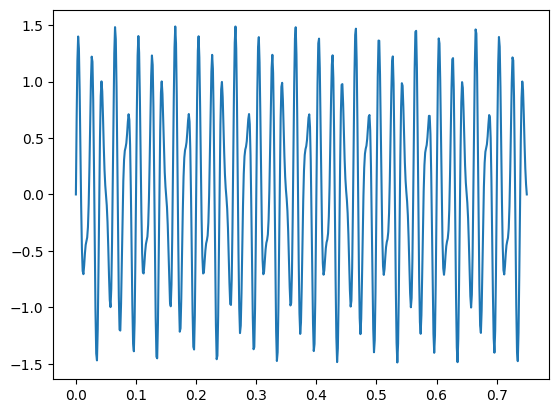

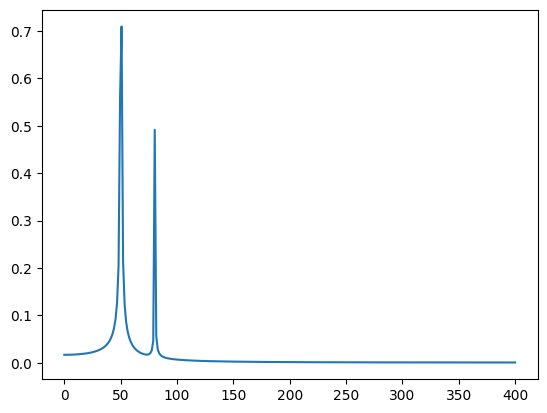

In [15]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


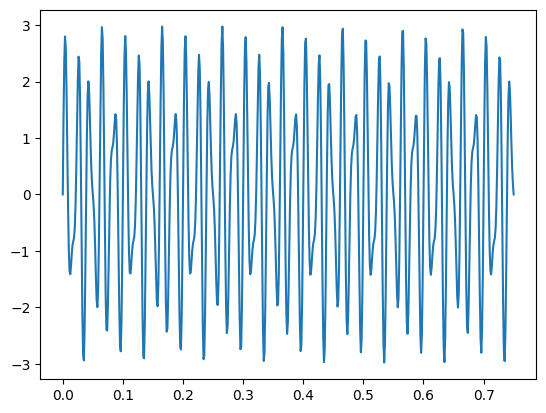

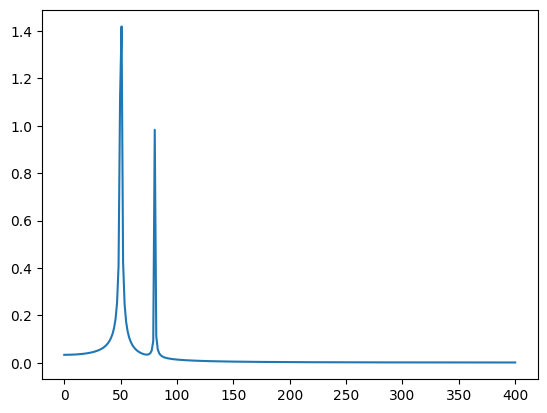

In [16]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = 2*(np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x))
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [62]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
# train_scaled = scaler.fit_transform(train_dataset_fft.X)
# test_scaled = scaler.fit_transform(test_dataset_fft.X)

In [18]:
# np.min(train_scaled), np.max(test_scaled)

In [63]:
train_HD = scaler.fit_transform(train_dataset_fft.X)
train_LD = None
# train_Y = train_dataset_fft.y
test_HD = scaler.fit_transform(test_dataset_fft.X)
test_LD = None
# test_Y = test_dataset_fft.y

## Computing accuracy values

# Reducing with Generic AE

The topological autoencoder can be used as a generic one by applying a lambda value of 0.

In [20]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder

kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 0
topo_reducer = TopologicalDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam = topoae_lambda,
    ae_kwargs = kwargs,
    input_shape = input_shape,
    patience=10
)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:286.0424, Loss-ae:286.0424, Loss-topo:86.4607
Epoch:2, P:10, Loss:277.5755, Loss-ae:277.5755, Loss-topo:127.7031
Epoch:3, P:10, Loss:293.3073, Loss-ae:293.3073, Loss-topo:144.2566
Epoch:4, P:9, Loss:287.2282, Loss-ae:287.2282, Loss-topo:95.6010
Epoch:5, P:8, Loss:271.0787, Loss-ae:271.0787, Loss-topo:170.4601
Epoch:6, P:10, Loss:275.5178, Loss-ae:275.5178, Loss-topo:407.4381
Epoch:7, P:9, Loss:230.2277, Loss-ae:230.2277, Loss-topo:459.6410
Epoch:8, P:10, Loss:182.8426, Loss-ae:182.8426, Loss-topo:435.0013
Epoch:9, P:10, Loss:157.2639, Loss-ae:157.2639, Loss-topo:921.3365
Epoch:10, P:10, Loss:155.9581, Loss-ae:155.9581, Loss-topo:1141.5674
Epoch:11, P:10, Loss:146.9791, Loss-ae:146.9791, Loss-topo:3017.7597
Epoch:12, P:10, Loss:144.0189, Loss-ae:144.0189, Loss-topo:1219.9019
Epoch:13, P:10, Loss:138.0344, Loss-ae:138.0344, Loss-topo:1361.5680
Epoch:14, P:10, Loss:142.1368, Loss-ae:142.1368, Loss-topo:2048.7737
Epoch:15, P:9, Loss:135.7814, Loss-ae:135.7814, Loss-topo

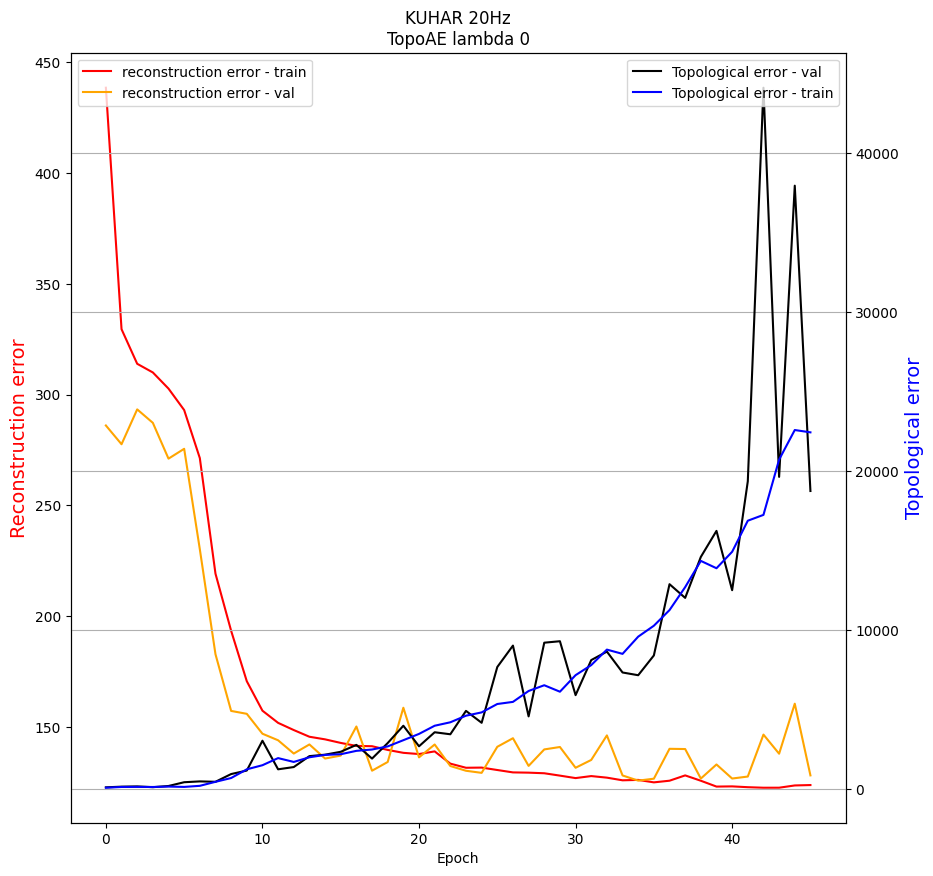

In [21]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [22]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [23]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)

## Set Reporter

In [24]:
reporter = ClassificationReport(
    use_accuracy=True, 
    use_f1_score=True,
    use_classification_report=False,
    use_confusion_matrix=False,
    plot_confusion_matrix=False
)

## Experiment for Random Forest

In [25]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [26]:
result = multi_run_experiment(train_pmd, test_pmd)

In [27]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.3944444444444445
F1 0.404503006081914


## Experiment for SVC

In [28]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [29]:
result = multi_run_experiment(train_pmd, test_pmd)

In [30]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.3333333333333333
F1 0.39446517962421107


## Experiment for KNN

In [31]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [32]:
result = multi_run_experiment(train_pmd, test_pmd)

In [33]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.37566137566137564
F1 0.3816031516655042


# Topological AE

In [34]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 100
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:410.3391, Loss-ae:396.8700, Loss-topo:0.1347
Epoch:2, P:10, Loss:358.1488, Loss-ae:333.7044, Loss-topo:0.2444
Epoch:3, P:10, Loss:367.3947, Loss-ae:342.4349, Loss-topo:0.2496
Epoch:4, P:9, Loss:326.2463, Loss-ae:308.7825, Loss-topo:0.1746
Epoch:5, P:10, Loss:249.1654, Loss-ae:245.5825, Loss-topo:0.0358
Epoch:6, P:10, Loss:243.9865, Loss-ae:241.9628, Loss-topo:0.0202
Epoch:7, P:10, Loss:273.3657, Loss-ae:268.4654, Loss-topo:0.0490
Epoch:8, P:9, Loss:218.7596, Loss-ae:218.0031, Loss-topo:0.0076
Epoch:9, P:10, Loss:241.7675, Loss-ae:234.3902, Loss-topo:0.0738
Epoch:10, P:9, Loss:246.1383, Loss-ae:239.5049, Loss-topo:0.0663
Epoch:11, P:8, Loss:270.4087, Loss-ae:264.6916, Loss-topo:0.0572
Epoch:12, P:7, Loss:255.4504, Loss-ae:244.2296, Loss-topo:0.1122
Epoch:13, P:6, Loss:239.9040, Loss-ae:236.7098, Loss-topo:0.0319
Epoch:14, P:5, Loss:221.0733, Loss-ae:216.4290, Loss-topo:0.0464
Epoch:15, P:4, Loss:210.5914, Loss-ae:195.7039, Loss-topo:0.1489
Epoch:16, P:10, Loss:184.29

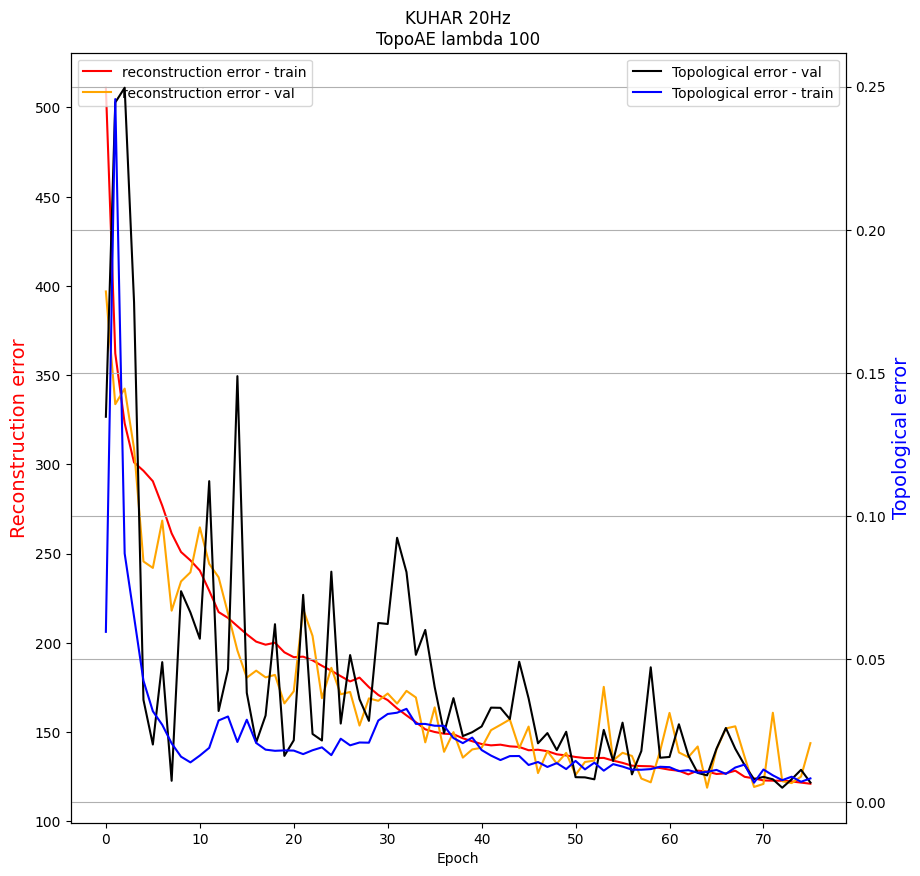

In [35]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [36]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [37]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)

## Experiment for Random Forest

In [38]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [39]:
result = multi_run_experiment(train_pmd, test_pmd)

In [40]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.5314814814814814
F1 0.5413915954813034


## Experiment for SVC

In [41]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [42]:
result = multi_run_experiment(train_pmd, test_pmd)

In [43]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.5291005291005291
F1 0.5694994640988837


## Experiment for KNN

In [44]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [45]:
result = multi_run_experiment(train_pmd, test_pmd)

In [46]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.5052910052910053
F1 0.5167556232755962


# Topological AE - Tanh

In [60]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 100
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver3', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver3
Using python to compute signatures
DeepAEforKuhar180ver3, Input: 180 Inner dim: 2


In [61]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

RuntimeError: running_mean should contain 1 elements not 200

In [36]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [37]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)

## Experiment for Random Forest

In [38]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [39]:
result = multi_run_experiment(train_pmd, test_pmd)

In [40]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.5314814814814814
F1 0.5413915954813034


## Experiment for SVC

In [41]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [42]:
result = multi_run_experiment(train_pmd, test_pmd)

In [43]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.5291005291005291
F1 0.5694994640988837


## Experiment for KNN

In [44]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [45]:
result = multi_run_experiment(train_pmd, test_pmd)

In [46]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.5052910052910053
F1 0.5167556232755962


# Reducing with UMAP

In [47]:
from librep.transforms import UMAP
umap_reducer = UMAP()
umap_reducer.fit(train_HD, train_Y)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [48]:
train_LD = np.reshape(umap_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(umap_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [49]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)

## Experiment for Random Forest

In [50]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [51]:
result = multi_run_experiment(train_pmd, test_pmd)

In [52]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.8076719576719575
F1 0.8134564116517085


## Experiment for SVC

In [53]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [54]:
result = multi_run_experiment(train_pmd, test_pmd)

In [55]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.8121693121693122
F1 0.8163249302080715


## Experiment for KNN

In [56]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [57]:
result = multi_run_experiment(train_pmd, test_pmd)

In [58]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.7936507936507936
F1 0.8008855473700524


In [59]:
assert 1==0

AssertionError: 

In [ ]:
test_applied_topoae = transform_topoae.transform(test_dataset_fft.X)
print('ORIGINAL', test_applied_topoae.shape)
test_applied_topoae = np.reshape(test_applied_topoae, (-1,2))
print('RESHAPED', test_applied_topoae.shape)

In [ ]:
train_applied_topoae = transform_topoae.transform(train_dataset_fft.X)
print('ORIGINAL', train_applied_topoae.shape)
train_applied_topoae = np.reshape(train_applied_topoae, (-1,2))
print('RESHAPED', train_applied_topoae.shape)

In [ ]:
from librep.transforms import TSNE
import numpy as np
import matplotlib.pyplot as plt

def visualize(X, Y, filtered=None, xlim=None, ylim=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()


In [ ]:
visualize(test_applied_topoae, test_dataset_fft.y)

In [ ]:
# filtered
filter_to_use = [0,1,2,3,4,5]
visualize(test_applied_topoae, test_dataset_fft.y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
for f in filter_to_use:
    visualize(test_applied_topoae, test_dataset_fft.y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
# visualize(test_applied_topoae, test_dataset_fft.y, filtered=[1])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

In [ ]:
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport
metrics_reporter = DimensionalityReductionQualityReport()
metrics_train_applied_topoae = metrics_reporter.evaluate([test_dataset_fft.X, test_applied_topoae])
print(metrics_train_applied_topoae)

In [ ]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier
from librep.metrics.report import ClassificationReport
import yaml

reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

In [ ]:
combined_train_dset = PandasMultiModalDataset(
    pd.concat([train, validation]),
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)


result = multi_run_experiment(combined_train_dset, test_dataset)
print(yaml.dump(result, sort_keys=True, indent=4))

In [ ]:
combined_train_dset_fft = transformer(combined_train_dset)

result = multi_run_experiment(combined_train_dset_fft, test_dataset_fft)
print(yaml.dump(result, sort_keys=True, indent=4))

In [ ]:
print(train_dataset_fft.y)

print(combined_train_dset.data.shape)

In [ ]:
import pandas as pd

# Using the latent space
train_applied_topoae = transform_topoae.transform(train_dataset_fft.X)
print('ORIGINAL', train_applied_topoae.shape)
train_applied_topoae = np.reshape(train_applied_topoae, (-1,2))
print('RESHAPED', train_applied_topoae.shape)

train_applied_topoae_pd = pd.DataFrame(train_applied_topoae)
train_applied_topoae_pd['y'] = train_dataset_fft.y
# print('FINAL', train_applied_topoae_pd)


topoae_train_dset = PandasMultiModalDataset(
    train_applied_topoae_pd,
    label_columns="y",
    as_array=True
)

test_applied_topoae_pd = pd.DataFrame(test_applied_topoae)
test_applied_topoae_pd['y'] = test_dataset_fft.y
# print('FINAL', test_applied_topoae_pd)

topoae_test_dset = PandasMultiModalDataset(
    test_applied_topoae_pd,
    label_columns="y",
    as_array=True
)
result = multi_run_experiment(topoae_train_dset, topoae_test_dset)
print(yaml.dump(result, sort_keys=True, indent=4))

# SVC

In [ ]:

result = multi_run_experiment(topoae_train_dset, topoae_test_dset)
print(yaml.dump(result, sort_keys=True, indent=4))

In [ ]:

result = multi_run_experiment(topoae_train_dset, topoae_test_dset)
print(yaml.dump(result, sort_keys=True, indent=4))

In [ ]:
data = [[-1, 2], [0, 2], [0, 3], [1, 4]]
data = [[-1, 2, 0, 2, 0, 3, 1, 5], [-1, 2, 0, 2, 0, 3, 1, 4]]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler


scaler = MinMaxScaler().fit(data)
print("MINMAX\n", scaler.transform(data))
scaler = MaxAbsScaler().fit(data)
print("MAXABS\n", scaler.transform(data))
scaler = StandardScaler().fit(data)
print("STANDARD\n", scaler.transform(data))

In [ ]:
X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]
transformer = MaxAbsScaler().fit(X)
transformer

transformer.transform(X)

In [ ]:
data = [[0, 0], [0, 0], [1, 1], [1, 1]]
print(scaler.fit(data))

print(scaler.mean_)

print(scaler.transform(data))




print(scaler.transform([[2, 2]]))